# Detecting emotions using the EEG brainwave

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**


![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/eeg.gif)

The notebook uses EEG brainwave data to predict the emotions of humans.


#### What is EEG?

Brain cells communicate with each other through electrical signals. 

Electroencephalography (EEG) is an electrophysiological monitoring method to record electrical activity of the brain. It is used for diagnosing or treating various disorders like brain tumors, stroke, sleep disorders etc.

Source - [Wikipedia - Electroencephalography](https://en.wikipedia.org/wiki/Electroencephalography#Medical_use)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt

## The dataset

The data was collected from two people (1 male, 1 female) for 3 minutes per state - positive, neutral, negative. A Muse EEG headband recorded the TP9, AF7, AF8 and TP10 EEG placements via dry electrodes. Six minutes of resting neutral data was also recorded.

The stimuli used to evoke the emotions are below

    1. Marley and Me - Negative (Twentieth Century Fox) Death Scene
    2. Up - Negative (Walt Disney Pictures) Opening Death Scene
    3. My Girl - Negative (Imagine Entertainment) Funeral Scene
    4. La La Land - Positive (Summit Entertainment) Opening musical number
    5. Slow Life - Positive (BioQuest Studios) Nature timelapse
    6. Funny Dogs - Positive (MashupZone) Funny dog clips

Dataset citation:

J. J. Bird, L. J. Manso, E. P. Ribiero, A. Ekart, and D. R. Faria, “A study on mental state classification using eeg-based brain-machine interface,”in 9th International Conference on Intelligent Systems, IEEE, 2018.

J. J. Bird, A. Ekart, C. D. Buckingham, and D. R. Faria, “Mental emotional sentiment classification with an eeg-based brain-machine interface,” in The International Conference on Digital Image and Signal Processing (DISP’19), Springer, 2019.

In [2]:
eeg = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/emotions.csv')
eeg

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,...,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,...,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,...,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,...,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,...,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,...,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90,NEUTRAL
2128,16.300,31.3,-284.0,14.30,23.9,4.200,1.090,4.460,4.720,6.63,...,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00,POSITIVE
2129,-0.547,28.3,-259.0,15.80,26.7,9.080,6.900,12.700,2.030,4.64,...,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00,NEGATIVE
2130,16.800,19.9,-288.0,8.34,26.0,2.460,1.580,-16.000,1.690,4.74,...,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00,NEGATIVE


In [3]:
# Number of samlpes in each class

eeg['label'].value_counts()

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

This is a balanced dataset.

In [4]:
# Checking the datatypes of the columns

eeg.dtypes

# mean_0_a    float64
mean_1_a      float64
mean_2_a      float64
mean_3_a      float64
mean_4_a      float64
               ...   
fft_746_b     float64
fft_747_b     float64
fft_748_b     float64
fft_749_b     float64
label          object
Length: 2549, dtype: object

In [5]:
# defining the input and output columns to separate the dataset in the later cells.

input_columns = list(eeg.columns[:-1])
output_columns = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']    # column names to be used after one-hot encoding

print("Number of input columns: ", len(input_columns))
#print("Input columns: ", ', '.join(input_columns))

print("Number of output columns: ", len(output_columns))
#print("Output columns: ", ', '.join(output_columns))

Number of input columns:  2548
Number of output columns:  3


In [6]:
# One hot encoding the labels

y = pd.get_dummies(eeg.label)
print(y)

# Adding the one hot encodings to the dataset
for x in output_columns:
    eeg[x] = y[x]

      NEGATIVE  NEUTRAL  POSITIVE
0            1        0         0
1            0        1         0
2            0        0         1
3            0        0         1
4            0        1         0
...        ...      ...       ...
2127         0        1         0
2128         0        0         1
2129         1        0         0
2130         1        0         0
2131         0        1         0

[2132 rows x 3 columns]


In [7]:
# Viewing the dataset again

eeg

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label,NEGATIVE,NEUTRAL,POSITIVE
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,...,23.50,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE,1,0,0
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,...,-23.30,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL,0,1,0
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,...,462.00,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE,0,0,1
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,...,299.00,132.0,-12.40,9.53,9.53,-12.40,POSITIVE,0,0,1
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,...,12.00,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,...,-21.70,95.2,-19.90,47.20,47.20,-19.90,NEUTRAL,0,1,0
2128,16.300,31.3,-284.0,14.30,23.9,4.200,1.090,4.460,4.720,6.63,...,594.00,-35.5,142.00,-59.80,-59.80,142.00,POSITIVE,0,0,1
2129,-0.547,28.3,-259.0,15.80,26.7,9.080,6.900,12.700,2.030,4.64,...,370.00,408.0,-169.00,-10.50,-10.50,-169.00,NEGATIVE,1,0,0
2130,16.800,19.9,-288.0,8.34,26.0,2.460,1.580,-16.000,1.690,4.74,...,124.00,-656.0,552.00,-271.00,-271.00,552.00,NEGATIVE,1,0,0


In [8]:
# Splitting into train, val and test set -- 80-10-10 split

# First, an 80-20 split
train_df, val_test_df = train_test_split(eeg, test_size = 0.2)

# Then split the 20% into half
val_df, test_df = train_test_split(val_test_df, test_size = 0.5)

print("Number of samples in...")
print("Training set: ", len(train_df))
print("Validation set: ", len(val_df))
print("Testing set: ", len(test_df))

Number of samples in...
Training set:  1705
Validation set:  213
Testing set:  214


In [9]:
# Splitting into X (input) and y (output)

Xtrain, ytrain = np.array(train_df[input_columns]), np.array(train_df[output_columns])

Xval, yval = np.array(val_df[input_columns]), np.array(val_df[output_columns])

Xtest, ytest = np.array(test_df[input_columns]), np.array(test_df[output_columns])

In [10]:
print("Range of values in X")

min(Xtrain[0]), max(Xtrain[0])

Range of values in X


(-36000000.0, 12500000000.0)

In [11]:
# Each feature has a different range. 
# Using min_max_scaler to scale them to values in the range [0,1].

min_max_scaler = MinMaxScaler()

# Fit on training set alone
Xtrain = min_max_scaler.fit_transform(Xtrain)

# Use it to transform val and test input
Xval = min_max_scaler.transform(Xval)
Xtest = min_max_scaler.transform(Xtest)

In [12]:
print("Range of values in X")

min(Xtrain[0]), max(Xtrain[0])

Range of values in X


(0.0, 1.0)

# Model

In [13]:
model = tf.keras.Sequential([
    layers.Dense(1024, activation = 'relu', input_shape = Xtrain[0].shape),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
])

model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [14]:
history = model.fit(Xtrain, ytrain, validation_data = (Xval, yval), epochs=128)

Epoch 1/128
54/54 [==============================] - 1s 15ms/step - loss: 0.9714 - accuracy: 0.5795 - val_loss: 0.4979 - val_accuracy: 0.8826
Epoch 2/128
54/54 [==============================] - 1s 11ms/step - loss: 0.5090 - accuracy: 0.7988 - val_loss: 0.5934 - val_accuracy: 0.7418
Epoch 3/128
54/54 [==============================] - 1s 11ms/step - loss: 0.4057 - accuracy: 0.8440 - val_loss: 0.3410 - val_accuracy: 0.8873
Epoch 4/128
54/54 [==============================] - 1s 11ms/step - loss: 0.4965 - accuracy: 0.7865 - val_loss: 0.3648 - val_accuracy: 0.8826
Epoch 5/128
54/54 [==============================] - 1s 11ms/step - loss: 0.3395 - accuracy: 0.8903 - val_loss: 0.2605 - val_accuracy: 0.9202
Epoch 6/128
54/54 [==============================] - 1s 11ms/step - loss: 0.2878 - accuracy: 0.9021 - val_loss: 0.2552 - val_accuracy: 0.8967
Epoch 7/128
54/54 [==============================] - 1s 11ms/step - loss: 0.3104 - accuracy: 0.8874 - val_loss: 0.2450 - val_accuracy: 0.9108
Epoch 

In [15]:
model.evaluate(Xtest, ytest)

7/7 [==============================] - 0s 4ms/step - loss: 0.3656 - accuracy: 0.8879


[0.3656277656555176, 0.8878504633903503]

In [16]:
def plot(history, variable):
    plt.plot(range(len(history[variable])), history[variable])
    plt.title(variable)

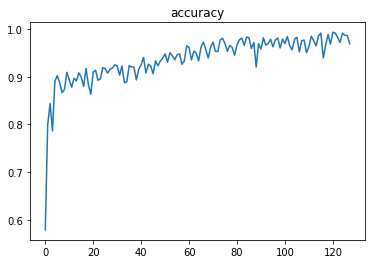

In [17]:
plot(history.history, "accuracy")

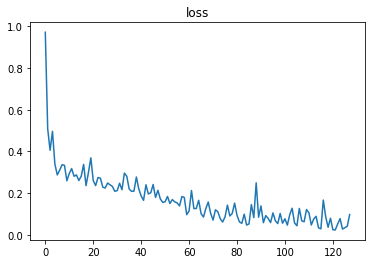

In [18]:
plot(history.history, "loss")

# deepC

In [19]:
model.save('eeg_emotion.h5')

!deepCC eeg_emotion.h5

reading [keras model] from 'eeg_emotion.h5'
Saved 'eeg_emotion.onnx'
reading onnx model from file  eeg_emotion.onnx
Model info:
  ir_vesion :  3 
  doc       : 
WARN (ONNX): terminal (input/output) dense_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_3's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_3) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  eeg_emotion_deepC/eeg_emotion.cpp
INFO (ONNX): model files are ready in dir eeg_emotion_deepC
g++ -std=c++11 -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 eeg_emotion_deepC/eeg_emotion.cpp -o eeg_emotion_deepC/eeg_emotion.exe
Model executable  eeg_emotion_deepC/eeg_emotion.exe


In [20]:
# Pick random test sample
i = random.randint(0, len(test_df)-1)

np.savetxt('sample.data', Xtest[i])

# run exe with input
!eeg_emotion_deepC/eeg_emotion.exe sample.data

# show predicted output
nn_out = np.loadtxt('dense_3.out')
print ("\nModel predicted the emotion: ", output_columns[np.argmax(nn_out)])

# actual output
print("Actual emotion: ", output_columns[np.argmax(ytest[i])])

reading file sample.data.
writing file dense_3.out.

Model predicted the emotion:  NEUTRAL
Actual emotion:  NEUTRAL
